# ClusterPC simulation 2

This notebook runs a simulation comparing PC with Cluster-PC. It also uses different graph and distribtuion methods and shows their effect on the algorithms. 

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")

import logging
logging.getLogger('rpy2').setLevel(logging.WARNING)

# Importing dependencies
%load_ext autoreload
%autoreload 2
import itertools
import yaml
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from clustercausal.experiments.ExperimentRunner import ExperimentRunner
from clustercausal.utils.Utils import *
from clustercausal.experiments.Utils import load_experiment_folder

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


The cell below executes a simulation according to the specified yaml file. To run several yaml files, it is recommended to modify the run_gridsearch.py file and run the simulation in the terminal with 

>```python clustercausal\experiments\run_gridsearch.py```

Depending on the number of experiments, the simulation can take a while. Simulation 2 takes around 35 minutes on a standard laptop. A sample yaml of all possible configurations can be found in ```clustercausal\experiments\configs\cluster_pc_all_param_configs.yaml```. It is not recommended to run that file, it is for reference only. 

To run the experiment, uncomment the code in the cell below. 

In [2]:
# config_path = 'clustercausal\experiments\configs\cluster_pc_simulation_2.yaml'
# config_path = config_path.replace('\\', '/')
# experiment = ExperimentRunner(config_path)
# experiment.run_gridsearch_experiment()

## Evaluating the simulation

First load the data. Make sure that the _results folder is empty, otherwise old experiments will also be loaded. Consider moving old experiments to a new folder _results_storage. 

In [4]:
# Can take a longer time depending on the numer of experiments, ca. 40sec for the 'mass_simulation' experiment
# This loads all experiment folder present in _results
# data = load_experiment_folder('clustercausal\experiments\_results')

# I had a different folder structure so I used
# data = load_experiment_folder('clustercausal\experiments\_results_storage\ClusterPC_simulation_2')

# To load the dataframe directly, use
data = pd.read_pickle('clustercausal\experiments\_results_dataframes_for_simulations\simulation_2_clusterPC_sensitivity_analysis.pkl')

# If one wants to load only specific simulation folders, put these in a separate folder named e.g. my_experiment and load
# data = load_experiment_folder('clustercausal\experiments\_results\my_experiment')
# where my_experiment contains the simulations of interest

In [5]:
# data_all also contains runs with n_clusters = 1
data_all = data.copy()
data_all.to_pickle('clustercausal\experiments\_results_storage\data_clusterPC_simulation_2.pkl')
data = data[data['n_clusters'] != 1]
# To look only at clusterings where at least two clusters were non-adjacent
data_nonadj_clusters = data[data['cluster_connectivity'] != 1]

In [6]:
data_all.describe()

,base_adj_f1_score,base_adj_false_negative,base_adj_false_positive,base_adj_precision,base_adj_recall,base_adj_true_negative,base_adj_true_positive,base_arrow_f1_score,base_arrow_f1_score_ce,base_arrow_false_negative,...,alpha,cluster_connectivity,empty_graph_shd,n_clusters,n_edges,n_nodes,noise_scale,sample_size,true_sid_lower,true_sid_upper
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1078.000000,1078.000000,1080.000000,...,1080.000000,900.000000,1080.000000,1080.000000,1080.000000,1080.0,1080.0,1080.0,0.0,0.0
mean,0.558015,33.237037,2.963889,0.863080,0.463783,51.439815,17.359259,0.343881,0.632246,40.306481,...,0.182000,0.878259,50.596296,3.500000,43.750000,15.0,1.0,1000.0,NaN,NaN
std,0.197564,24.538131,2.952135,0.119324,0.253751,25.915885,3.956273,0.163435,0.171687,24.603653,...,0.178677,0.172465,26.367545,1.708616,24.346177,0.0,0.0,0.0,NaN,NaN
min,0.231579,0.000000,0.000000,0.187500,0.134146,12.000000,6.000000,0.037037,0.125000,1.000000,...,0.010000,0.166667,7.000000,1.000000,15.000000,15.0,1.0,1000.0,NaN,NaN
25%,0.391641,9.000000,1.000000,0.809066,0.253679,25.000000,15.000000,0.228571,0.514286,17.000000,...,0.050000,0.800000,26.000000,2.000000,26.250000,15.0,1.0,1000.0,NaN,NaN
50%,0.507463,31.000000,2.000000,0.888889,0.360000,53.000000,17.000000,0.311111,0.642857,40.500000,...,0.100000,1.000000,50.000000,3.500000,40.000000,15.0,1.0,1000.0,NaN,NaN
75%,0.723588,58.000000,4.000000,0.947368,0.653846,76.000000,20.000000,0.434783,0.756757,64.000000,...,0.250000,1.000000,79.000000,5.000000,57.500000,15.0,1.0,1000.0,NaN,NaN
max,1.000000,75.000000,26.000000,1.000000,1.000000,98.000000,29.000000,0.923077,1.000000,84.000000,...,0.500000,1.000000,89.000000,6.000000,80.000000,15.0,1.0,1000.0,NaN,NaN


It is possible to load the specific graphs of one experiment: 

In [7]:
# # Change this according to the experiment folder you want to load - this specific folder is not included in the repo
# experiment_folder = 'clustercausal\experiments\_results\ClusterPC_simulation_2\erdos_renyi_15_nodes_15_edges_1_clusters_exp14-13-40-503'
# base_est_graph, cluster_est_graph, cluster_dag = load_experiment_graphs(experiment_folder)
# cluster_dag.true_dag.draw_pydot_graph()

### Data exploration

In [8]:
pd.set_option('display.max_columns', None)
data[:10]

,base_adj_f1_score,base_adj_false_negative,base_adj_false_positive,base_adj_precision,base_adj_recall,base_adj_true_negative,base_adj_true_positive,base_arrow_f1_score,base_arrow_f1_score_ce,base_arrow_false_negative,base_arrow_false_negative_ce,base_arrow_false_positive,base_arrow_false_positive_ce,base_arrow_precision,base_arrow_precision_ce,base_arrow_recall,base_arrow_recall_ce,base_arrow_true_negative,base_arrow_true_negative_ce,base_arrow_true_positive,base_arrow_true_positive_ce,base_base_shd,base_sid_lower,cluster_adj_f1_score,cluster_adj_false_negative,cluster_adj_false_positive,cluster_adj_precision,cluster_adj_recall,cluster_adj_true_negative,cluster_adj_true_positive,cluster_arrow_f1_score,cluster_arrow_f1_score_ce,cluster_arrow_false_negative,cluster_arrow_false_negative_ce,cluster_arrow_false_positive,cluster_arrow_false_positive_ce,cluster_arrow_precision,cluster_arrow_precision_ce,cluster_arrow_recall,cluster_arrow_recall_ce,cluster_arrow_true_negative,cluster_arrow_true_negative_ce,cluster_arrow_true_positive,cluster_arrow_true_positive_ce,cluster_cluster_shd,cluster_sid_lower,pruned_base_adj_f1_score,pruned_base_adj_false_negative,pruned_base_adj_false_positive,pruned_base_adj_precision,pruned_base_adj_recall,pruned_base_adj_true_negative,pruned_base_adj_true_positive,pruned_base_arrow_f1_score,pruned_base_arrow_f1_score_ce,pruned_base_arrow_false_negative,pruned_base_arrow_false_negative_ce,pruned_base_arrow_false_positive,pruned_base_arrow_false_positive_ce,pruned_base_arrow_precision,pruned_base_arrow_precision_ce,pruned_base_arrow_recall,pruned_base_arrow_recall_ce,pruned_base_arrow_true_negative,pruned_base_arrow_true_negative_ce,pruned_base_arrow_true_positive,pruned_base_arrow_true_positive_ce,pruned_base_pruned_base_shd,pruned_base_sid_lower,Base indep tests,C-PC indep tests,alpha,cluster_connectivity,dag_method,distribution_type,edge_ratios,empty_graph_shd,indep_test,n_clusters,n_edges,n_nodes,noise_scale,sample_size,scm_method,seed,true_sid_lower,true_sid_upper,weight_range
15,0.880000,3.0,0.0,1.000000,0.785714,91.0,11.0,0.500000,0.588235,9.0,6.0,1.0,1.0,0.833333,0.833333,0.357143,0.454545,210.0,213.0,5.0,5.0,4.0,NaN,0.923077,2.0,0.0,1.000000,0.857143,91.0,12.0,0.782609,0.857143,5.0,3.0,0.0,0.0,1.000000,1.000000,0.642857,0.750000,211.0,213.0,9.0,9.0,2.0,NaN,0.880000,3.0,0.0,1.000000,0.785714,91.0,11.0,0.500000,0.588235,9.0,6.0,1.0,1.0,0.833333,0.833333,0.357143,0.454545,210.0,213.0,5.0,5.0,4.0,NaN,778.0,512.0,0.01,1.0,erdos_renyi,exp,"[0.15, 0.14, 0.14]",14.0,fisherz,2.0,15.0,15.0,1.0,1000.0,linear,None,NaN,NaN,"(-1, 2)"
16,0.916667,2.0,0.0,1.000000,0.846154,92.0,11.0,0.631579,0.705882,7.0,5.0,0.0,0.0,1.000000,1.000000,0.461538,0.545455,212.0,214.0,6.0,6.0,2.0,NaN,0.880000,2.0,1.0,0.916667,0.846154,91.0,11.0,0.880000,1.000000,2.0,0.0,1.0,0.0,0.916667,1.000000,0.846154,1.000000,211.0,214.0,11.0,11.0,3.0,NaN,0.916667,2.0,0.0,1.000000,0.846154,92.0,11.0,0.631579,0.705882,7.0,5.0,0.0,0.0,1.000000,1.000000,0.461538,0.545455,212.0,214.0,6.0,6.0,2.0,NaN,389.0,293.0,0.05,1.0,erdos_renyi,exp,"[0.12, 0.12, 0.12]",13.0,fisherz,2.0,15.0,15.0,1.0,1000.0,linear,None,NaN,NaN,"(-1, 2)"
17,0.903226,3.0,0.0,1.000000,0.823529,88.0,14.0,0.592593,0.666667,9.0,6.0,2.0,2.0,0.800000,0.800000,0.470588,0.571429,206.0,209.0,8.0,8.0,5.0,NaN,0.903226,3.0,0.0,1.000000,0.823529,88.0,14.0,0.642857,0.720000,8.0,5.0,2.0,2.0,0.818182,0.818182,0.529412,0.642857,206.0,209.0,9.0,9.0,5.0,NaN,0.903226,3.0,0.0,1.000000,0.823529,88.0,14.0,0.592593,0.666667,9.0,6.0,2.0,2.0,0.800000,0.800000,0.470588,0.571429,206.0,209.0,8.0,8.0,5.0,NaN,645.0,619.0,0.10,1.0,erdos_renyi,exp,"[0.33, 0.14, 0.14]",17.0,fisherz,2.0,15.0,15.0,1.0,1000.0,linear,None,NaN,NaN,"(-1, 2)"
18,0.742857,1.0,8.0,0.619048,0.928571,83.0,13.0,0.588235,0.800000,4.0,3.0,10.0,2.0,0.500000,0.833333,0.714286,0.769231,201.0,210.0,10.0,10.0,11.0,NaN,0.722222,1.0,9.0,0.590909,0.928571,82.0,13.0,0.647059,0.880000,3.0,2.0,9.0,1.0,0.550000,0.916667,0.785714,0.846154,202.0,211.0,11.0,11.0,

The data contains the following information on the settings of the simulation:

In [9]:
# settings_results = {
#             "n_nodes": simulation.n_nodes,
#             "n_edges": simulation.n_edges,
#             "n_clusters": simulation.n_clusters,
#             "edge_ratios": edge_ratios,
#             "dag_method": simulation.dag_method,
#             "distribution_type": simulation.distribution_type,
#             "scm_method": simulation.scm_method,
#             "weight_range": simulation.weight_range,
#             "sample_size": simulation.sample_size,
#             "seed": simulation.seed,
#             "noise_scale": simulation.noise_scale,
#             # "n_c_edges": simulation.n_c_edges,
#             "alpha": simulation.alpha,
#             "true_sid_lower": true_sid_bounds["sid_lower"],
#             "true_sid_upper": true_sid_bounds["sid_upper"],
#             "indep_test": self.indep_test,
#             "empty_graph_shd": empty_graph_shd,
#             "cluster_connectivity": cluster_connectivity,
#             "C-PC indep tests": clust_no_indep_tests,
#             "Base indep tests": one_clust_no_indep_tests,
#         }

In addition the metrics for the runs are as follows (where pruned is the results of PC but edges that could be removed from C-DAG are removed):

In [10]:
# cluster_adjacency_confusion,
# cluster_arrow_confusion,
# cluster_shd,
# cluster_sid,

# base_adjacency_confusion,
# base_arrow_confusion,
# base_shd,
# base_sid,

# pruned_base_adjacency_confusion,
# pruned_base_arrow_confusion,
# pruned_base_shd,
# pruned_base_sid,

Pruned and base results are identical, as it seems PC never failed to delete an edge between non-adjacent clusters. 

In [11]:
data_all.describe()

,base_adj_f1_score,base_adj_false_negative,base_adj_false_positive,base_adj_precision,base_adj_recall,base_adj_true_negative,base_adj_true_positive,base_arrow_f1_score,base_arrow_f1_score_ce,base_arrow_false_negative,base_arrow_false_negative_ce,base_arrow_false_positive,base_arrow_false_positive_ce,base_arrow_precision,base_arrow_precision_ce,base_arrow_recall,base_arrow_recall_ce,base_arrow_true_negative,base_arrow_true_negative_ce,base_arrow_true_positive,base_arrow_true_positive_ce,base_base_shd,base_sid_lower,cluster_adj_f1_score,cluster_adj_false_negative,cluster_adj_false_positive,cluster_adj_precision,cluster_adj_recall,cluster_adj_true_negative,cluster_adj_true_positive,cluster_arrow_f1_score,cluster_arrow_f1_score_ce,cluster_arrow_false_negative,cluster_arrow_false_negative_ce,cluster_arrow_false_positive,cluster_arrow_false_positive_ce,cluster_arrow_precision,cluster_arrow_precision_ce,cluster_arrow_recall,cluster_arrow_recall_ce,cluster_arrow_true_negative,cluster_arrow_true_negative_ce,cluster_arrow_true_positive,cluster_arrow_true_positive_ce,cluster_cluster_shd,cluster_sid_lower,pruned_base_adj_f1_score,pruned_base_adj_false_negative,pruned_base_adj_false_positive,pruned_base_adj_precision,pruned_base_adj_recall,pruned_base_adj_true_negative,pruned_base_adj_true_positive,pruned_base_arrow_f1_score,pruned_base_arrow_f1_score_ce,pruned_base_arrow_false_negative,pruned_base_arrow_false_negative_ce,pruned_base_arrow_false_positive,pruned_base_arrow_false_positive_ce,pruned_base_arrow_precision,pruned_base_arrow_precision_ce,pruned_base_arrow_recall,pruned_base_arrow_recall_ce,pruned_base_arrow_true_negative,pruned_base_arrow_true_negative_ce,pruned_base_arrow_true_positive,pruned_base_arrow_true_positive_ce,pruned_base_pruned_base_shd,pruned_base_sid_lower,Base indep tests,C-PC indep tests,alpha,cluster_connectivity,empty_graph_shd,n_clusters,n_edges,n_nodes,noise_scale,sample_size,true_sid_lower,true_sid_upper
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1078.000000,1078.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,0.0,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1079.000000,1079.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,0.0,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1078.000000,1078.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,0.0,1080.000000,1080.000000,1080.000000,900.000000,1080.000000,1080.000000,1080.000000,1080.0,1080.0,1080.0,0.0,0.0
mean,0.558015,33.237037,2.963889,0.863080,0.463783,51.439815,17.359259,0.343881,0.632246,40.306481,7.069444,6.856481,4.170370,0.610799,0.709428,0.264068,0.577924,167.547222,203.470370,10.289815,10.289815,40.371296,NaN,0.621049,28.457407,4.598148,0.836135,0.545386,49.805556,22.138889,0.526171,0.841170,32.137037,3.679630,6.642593,2.333333,0.731029,0.872837,0.452331,0.815458,167.761111,200.527778,18.459259,18.459259,35.388889,NaN,0.558015,33.237037,2.963889,0.863080,0.463783,51.439815,17.359259,0.343881,0.632246,40.306481,7.069444,6.856481,4.170370,0.610799,0.709428,0.264068,0.577924,167.547222,203.470370,10.289815,10.289815,40.371296,NaN,4580.461111,2994.563889,0.182000,0.878259,50.596296,3.500000,43.750000,15.0,1.0,1000.0,NaN,NaN
std,0.197564,24.538131,2.952135,0.119324,0.253751,25.915885,3.956273,0.163435,0.171687,24.603653,2.925994,4.285324,2.853652,0.200017,0.185393,0.165490,0.177350,26.462059,5.503647,4.588163,4.588163,24.568304,NaN,0.160947,21.838272,3.999026,0.129122,0.231577,25.841951,7.121556,0.186572,0.158696,22.619177,3.083808,4.448453,2.388573,0.174157,0.146137,0.228972,0.176456,26.424677,7.5200

In [12]:
data.describe()

,base_adj_f1_score,base_adj_false_negative,base_adj_false_positive,base_adj_precision,base_adj_recall,base_adj_true_negative,base_adj_true_positive,base_arrow_f1_score,base_arrow_f1_score_ce,base_arrow_false_negative,base_arrow_false_negative_ce,base_arrow_false_positive,base_arrow_false_positive_ce,base_arrow_precision,base_arrow_precision_ce,base_arrow_recall,base_arrow_recall_ce,base_arrow_true_negative,base_arrow_true_negative_ce,base_arrow_true_positive,base_arrow_true_positive_ce,base_base_shd,base_sid_lower,cluster_adj_f1_score,cluster_adj_false_negative,cluster_adj_false_positive,cluster_adj_precision,cluster_adj_recall,cluster_adj_true_negative,cluster_adj_true_positive,cluster_arrow_f1_score,cluster_arrow_f1_score_ce,cluster_arrow_false_negative,cluster_arrow_false_negative_ce,cluster_arrow_false_positive,cluster_arrow_false_positive_ce,cluster_arrow_precision,cluster_arrow_precision_ce,cluster_arrow_recall,cluster_arrow_recall_ce,cluster_arrow_true_negative,cluster_arrow_true_negative_ce,cluster_arrow_true_positive,cluster_arrow_true_positive_ce,cluster_cluster_shd,cluster_sid_lower,pruned_base_adj_f1_score,pruned_base_adj_false_negative,pruned_base_adj_false_positive,pruned_base_adj_precision,pruned_base_adj_recall,pruned_base_adj_true_negative,pruned_base_adj_true_positive,pruned_base_arrow_f1_score,pruned_base_arrow_f1_score_ce,pruned_base_arrow_false_negative,pruned_base_arrow_false_negative_ce,pruned_base_arrow_false_positive,pruned_base_arrow_false_positive_ce,pruned_base_arrow_precision,pruned_base_arrow_precision_ce,pruned_base_arrow_recall,pruned_base_arrow_recall_ce,pruned_base_arrow_true_negative,pruned_base_arrow_true_negative_ce,pruned_base_arrow_true_positive,pruned_base_arrow_true_positive_ce,pruned_base_pruned_base_shd,pruned_base_sid_lower,Base indep tests,C-PC indep tests,alpha,cluster_connectivity,empty_graph_shd,n_clusters,n_edges,n_nodes,noise_scale,sample_size,true_sid_lower,true_sid_upper
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,899.000000,899.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,0.0,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,0.0,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,899.000000,899.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,0.0,900.000000,900.000000,900.000000,900.000000,900.000000,900.000,900.000000,900.0,900.0,900.0,0.0,0.0
mean,0.559182,33.222222,2.924444,0.864585,0.464137,51.490000,17.363333,0.346783,0.635757,40.238889,7.016667,6.777778,4.125556,0.615787,0.713506,0.266378,0.581592,167.636667,203.511111,10.346667,10.346667,40.272222,NaN,0.634823,27.486667,4.885556,0.832252,0.562061,49.528889,23.098889,0.565326,0.886229,30.435556,2.948889,6.521111,1.921111,0.760063,0.909596,0.492294,0.866634,167.893333,199.980000,20.150000,20.150000,34.293333,NaN,0.559182,33.222222,2.924444,0.864585,0.464137,51.490000,17.363333,0.346783,0.635757,40.238889,7.016667,6.777778,4.125556,0.615787,0.713506,0.266378,0.581592,167.636667,203.511111,10.346667,10.346667,40.272222,NaN,4572.567778,2669.491111,0.182000,0.878259,50.585556,4.000,43.750000,15.0,1.0,1000.0,NaN,NaN
std,0.198208,24.527018,2.907713,0.117717,0.254046,25.958144,3.944863,0.165063,0.170022,24.626095,2.897728,4.265853,2.824652,0.198433,0.183026,0.167875,0.174870,26.545870,5.472846,4.553213,4.553213,24.622225,NaN,0.149663,21.110094,4.086824,0.129235,0.223503,25.860932,7.218826,0.166598,0.107627,21.831320,2.518817,4.456014,2.010926,0.151157,0.099307,0.220628,0.120622,26.500063,7.725234,7.435802,7.435802,21.214634,NaN,0.198208,24.527018,2.907713,0.117717,0.254046,

The precision of C-PC is slightly lower, but the recall is higher. In total C-PC has a higher F1 score.

In [13]:
data_nonadj_clusters.describe()

,base_adj_f1_score,base_adj_false_negative,base_adj_false_positive,base_adj_precision,base_adj_recall,base_adj_true_negative,base_adj_true_positive,base_arrow_f1_score,base_arrow_f1_score_ce,base_arrow_false_negative,base_arrow_false_negative_ce,base_arrow_false_positive,base_arrow_false_positive_ce,base_arrow_precision,base_arrow_precision_ce,base_arrow_recall,base_arrow_recall_ce,base_arrow_true_negative,base_arrow_true_negative_ce,base_arrow_true_positive,base_arrow_true_positive_ce,base_base_shd,base_sid_lower,cluster_adj_f1_score,cluster_adj_false_negative,cluster_adj_false_positive,cluster_adj_precision,cluster_adj_recall,cluster_adj_true_negative,cluster_adj_true_positive,cluster_arrow_f1_score,cluster_arrow_f1_score_ce,cluster_arrow_false_negative,cluster_arrow_false_negative_ce,cluster_arrow_false_positive,cluster_arrow_false_positive_ce,cluster_arrow_precision,cluster_arrow_precision_ce,cluster_arrow_recall,cluster_arrow_recall_ce,cluster_arrow_true_negative,cluster_arrow_true_negative_ce,cluster_arrow_true_positive,cluster_arrow_true_positive_ce,cluster_cluster_shd,cluster_sid_lower,pruned_base_adj_f1_score,pruned_base_adj_false_negative,pruned_base_adj_false_positive,pruned_base_adj_precision,pruned_base_adj_recall,pruned_base_adj_true_negative,pruned_base_adj_true_positive,pruned_base_arrow_f1_score,pruned_base_arrow_f1_score_ce,pruned_base_arrow_false_negative,pruned_base_arrow_false_negative_ce,pruned_base_arrow_false_positive,pruned_base_arrow_false_positive_ce,pruned_base_arrow_precision,pruned_base_arrow_precision_ce,pruned_base_arrow_recall,pruned_base_arrow_recall_ce,pruned_base_arrow_true_negative,pruned_base_arrow_true_negative_ce,pruned_base_arrow_true_positive,pruned_base_arrow_true_positive_ce,pruned_base_pruned_base_shd,pruned_base_sid_lower,Base indep tests,C-PC indep tests,alpha,cluster_connectivity,empty_graph_shd,n_clusters,n_edges,n_nodes,noise_scale,sample_size,true_sid_lower,true_sid_upper
count,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,0.0,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,0.0,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,0.0,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.0,417.0,417.0,0.0,0.0
mean,0.613622,26.865707,2.923261,0.863344,0.540058,58.378897,16.832134,0.383271,0.640144,33.616307,6.750600,6.513189,3.858513,0.626084,0.725695,0.308170,0.584133,174.788969,204.309353,10.081535,10.081535,33.647482,NaN,0.683436,21.177458,5.158273,0.820270,0.644706,56.143885,22.520384,0.638167,0.927616,23.079137,1.901679,6.122302,1.304556,0.778635,0.940886,0.593473,0.915803,175.179856,201.175060,20.618705,20.618705,27.640288,NaN,0.613622,26.865707,2.923261,0.863344,0.540058,58.378897,16.832134,0.383271,0.640144,33.616307,6.750600,6.513189,3.858513,0.626084,0.725695,0.308170,0.584133,174.788969,204.309353,10.081535,10.081535,33.647482,NaN,4035.211031,2029.055156,0.189808,0.737250,43.697842,5.026379,38.297362,15.0,1.0,1000.0,NaN,NaN
std,0.205361,24.679118,3.272681,0.132053,0.272973,26.523762,4.181648,0.174715,0.173975,24.792243,2.949928,4.536756,2.837190,0.208914,0.185748,0.183161,0.179640,27.214578,5.810942,4.634535,4.634535,24.720514,NaN,0.148385,20.352829,4.550347,0.147972,0.228748,26.530070,8.209996,0.158778,0.072930,20.916523,1.833823,4.641152,1.513021,0.154644,0.069868,0.226315,0.080915,27.063650,8.692147,7.895102,7.895102,20.361401,NaN,0.205361,24.679118,3.272681,0.132053,0.2

In [14]:
prec_recall_metrics_with_pruned = ['base_adj_precision', 'pruned_base_adj_precision', 'cluster_adj_precision', \
           'base_adj_recall', 'pruned_base_adj_recall','cluster_adj_recall', \
           'base_adj_f1_score', 'pruned_base_adj_f1_score', 'cluster_adj_f1_score']
prec_recall_metrics = ['base_adj_precision', 'cluster_adj_precision', \
              'base_adj_recall', 'cluster_adj_recall', \
                'base_adj_f1_score', 'cluster_adj_f1_score']
data[prec_recall_metrics].describe()

,base_adj_precision,cluster_adj_precision,base_adj_recall,cluster_adj_recall,base_adj_f1_score,cluster_adj_f1_score
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,0.864585,0.832252,0.464137,0.562061,0.559182,0.634823
std,0.117717,0.129235,0.254046,0.223503,0.198208,0.149663
min,0.187500,0.176471,0.134146,0.194444,0.231579,0.292683
25%,0.809524,0.777778,0.256332,0.379638,0.393213,0.520548
50%,0.888889,0.850926,0.360000,0.500000,0.507252,0.611341
75%,0.947368,0.923077,0.653846,0.742349,0.720328,0.736842
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
indep_test_metrics = ['Base indep tests', 'C-PC indep tests']
dist_metrics = ['base_base_shd', 'cluster_cluster_shd', 'empty_graph_shd']
overall_metrics = prec_recall_metrics + dist_metrics + indep_test_metrics

In [16]:
pd.DataFrame(data_all[overall_metrics].mean())

,0
base_adj_precision,0.863080
cluster_adj_precision,0.836135
base_adj_recall,0.463783
cluster_adj_recall,0.545386
base_adj_f1_score,0.558015
cluster_adj_f1_score,0.621049
base_base_shd,40.371296
cluster_cluster_shd,35.388889
empty_graph_shd,50.596296
Base indep tests,4580.461111


In [17]:
print(pd.DataFrame(data_all[overall_metrics].mean()).to_latex())

\begin{tabular}{lr}
\toprule
{} &            0 \\
\midrule
base\_adj\_precision    &     0.863080 \\
cluster\_adj\_precision &     0.836135 \\
base\_adj\_recall       &     0.463783 \\
cluster\_adj\_recall    &     0.545386 \\
base\_adj\_f1\_score     &     0.558015 \\
cluster\_adj\_f1\_score  &     0.621049 \\
base\_base\_shd         &    40.371296 \\
cluster\_cluster\_shd   &    35.388889 \\
empty\_graph\_shd       &    50.596296 \\
Base indep tests      &  4580.461111 \\
C-PC indep tests      &  2994.563889 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [18]:
# # colors = ['#A4C2F4', '#3333FF', '#64d2a6', '#065535', '#e49645', '#b45f06']
# # colors = ['#A4C2F4', '#3333FF', '#64d2a6', '#065535', '#e49645', '#b45f06']
# # colors = ['#A4C2F4', '#3333FF', '#64d2a6', '#065535', '#e49645', '#b45f06']
# colors = ['#9ABCE4', '#005293', '#C7D97D', '#7D922A', '#FAD080', '#F7811E'] #TUM COLORS
# mean_values = data_all[prec_recall_metrics].mean()
# ax = mean_values.plot(kind='bar', figsize=(15, 8), color=colors)
# plt.title('Precision, Recall and F1-Score', fontsize=20)
# plt.xlabel('Metric', fontsize=18)
# plt.tick_params(axis='both', which='major', labelsize=14)
# plt.tick_params(axis='x', which='major', labelsize=16, rotation=30)
# label_names = ['PC precision', 'Cluster PC precision', 'PC recall', 'Cluster PC recall', 'PC F1-score', 'Cluster PC F1-score']
# ax.set_xticklabels(label_names)
# plt.show()

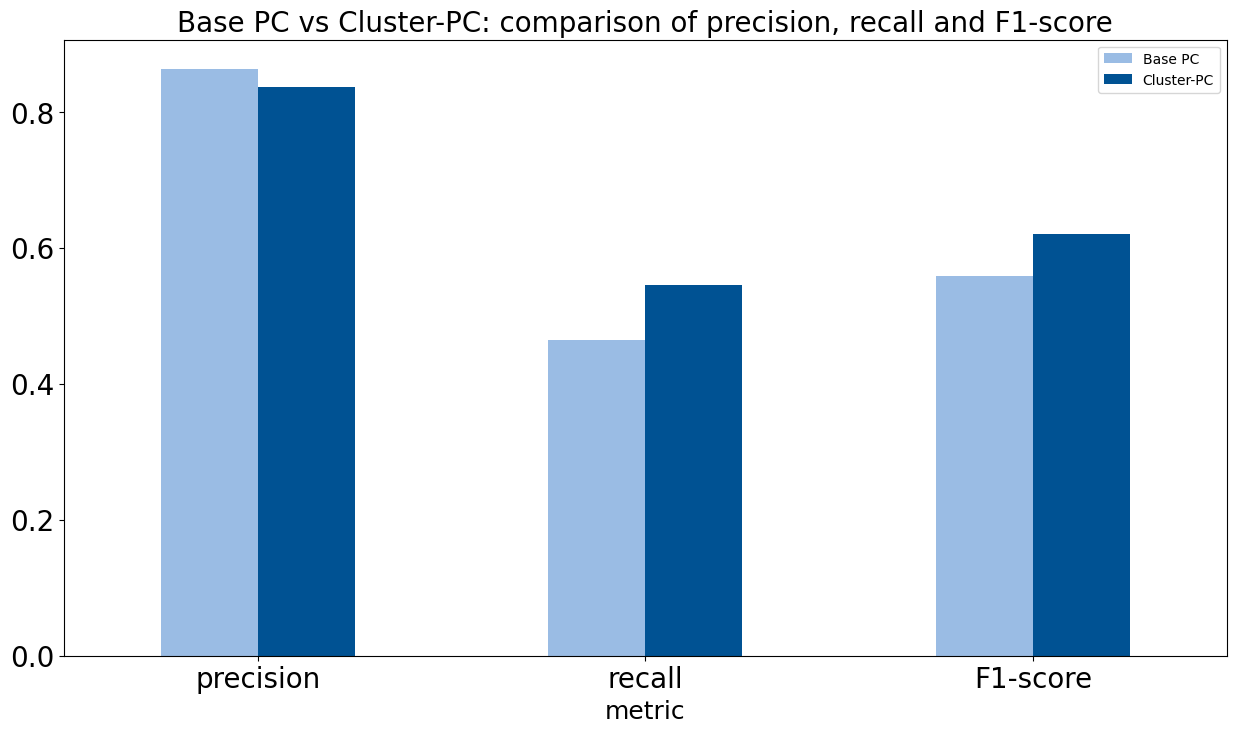

In [19]:
mean_values = data_all[prec_recall_metrics].mean()

# Group data into a new DataFrame
grouped_data = pd.DataFrame({
    'Base PC': [mean_values['base_adj_precision'],mean_values['base_adj_recall'], mean_values['base_adj_f1_score']],
    'Cluster-PC': [mean_values['cluster_adj_precision'], mean_values['cluster_adj_recall'], mean_values['cluster_adj_f1_score']],
})

# Set the index to the group names
grouped_data.index = ['precision', 'recall', 'F1-score' ]

# Plot the data
# colors = ['#A4C2F4', '#3333FF', '#64d2a6', '#065535', '#e49645', '#b45f06']
# colors = ['#64a0c8', '#005293', '#64d2a6', '#065535', '#e49645', '#b45f06']
# colors = ['#A4C2F4', '#3333FF', '#4D68D5']
colors = ['#9ABCE4', '#005293', '#5E94D4']
ax = grouped_data.plot(kind='bar', figsize=(15, 8), color=colors[:2])

# Customizing the plot
plt.title('Base PC vs Cluster-PC: comparison of precision, recall and F1-score', fontsize=20)
plt.xlabel('metric', fontsize=18)
plt.xticks(rotation=0)
plt.tick_params(axis='both', which='major', labelsize=20)

# Show the plot
plt.show()

In [20]:
data_nonadj_clusters[prec_recall_metrics].describe()

,base_adj_precision,cluster_adj_precision,base_adj_recall,cluster_adj_recall,base_adj_f1_score,cluster_adj_f1_score
count,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000
mean,0.863344,0.820270,0.540058,0.644706,0.613622,0.683436
std,0.132053,0.147972,0.272973,0.228748,0.205361,0.148385
min,0.187500,0.176471,0.159420,0.250000,0.255814,0.292683
25%,0.807692,0.761905,0.280000,0.433735,0.422018,0.566667
50%,0.892857,0.844444,0.476190,0.615385,0.603774,0.666667
75%,0.952381,0.925926,0.791667,0.857143,0.790698,0.800000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
# latex = data_nonadj_clusters[prec_recall_metrics].describe().style.to_latex()
# print(latex)

C-PC has slightly lower true negative and higher true positive. Positive is defined as an edge that is present in the true graph. 

In [22]:
count_metrics_with_pruned = ['base_adj_false_negative', 'pruned_base_adj_false_negative', 'cluster_adj_false_negative', \
                 'base_adj_false_positive', 'pruned_base_adj_false_positive','cluster_adj_false_positive', \
                    'base_adj_true_negative', 'pruned_base_adj_true_negative', 'cluster_adj_true_negative', \
                        'base_adj_true_positive', 'pruned_base_adj_true_positive', 'cluster_adj_true_positive']
count_metrics = ['base_adj_false_negative', 'cluster_adj_false_negative', \
                    'base_adj_false_positive','cluster_adj_false_positive', \
                        'base_adj_true_negative', 'cluster_adj_true_negative', \
                            'base_adj_true_positive', 'cluster_adj_true_positive']
data[count_metrics].describe()

,base_adj_false_negative,cluster_adj_false_negative,base_adj_false_positive,cluster_adj_false_positive,base_adj_true_negative,cluster_adj_true_negative,base_adj_true_positive,cluster_adj_true_positive
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,33.222222,27.486667,2.924444,4.885556,51.490000,49.528889,17.363333,23.098889
std,24.527018,21.110094,2.907713,4.086824,25.958144,25.860932,3.944863,7.218826
min,0.000000,0.000000,0.000000,0.000000,12.000000,11.000000,6.000000,6.000000
25%,9.000000,7.000000,1.000000,2.000000,25.000000,23.000000,15.000000,19.000000
50%,32.000000,25.000000,2.000000,4.000000,53.000000,51.000000,17.000000,23.000000
75%,58.000000,48.000000,4.000000,7.000000,77.000000,73.000000,20.000000,27.000000
max,75.000000,67.000000,26.000000,28.000000,98.000000,98.000000,29.000000,45.000000


Calculating the total of correctly identified edges ratio: $TCIE = \frac{TP + TN}{TP + TN + FP + FN}$. 

In total C-PC has slightly higher TCIE. 

In [23]:
data['cluster_TCIE'] = (data['cluster_adj_true_positive'] + 
                data['cluster_adj_true_negative']) / (data['cluster_adj_true_positive'] + 
                                                                                        data['cluster_adj_true_negative'] + 
                                                                                        data['cluster_adj_false_positive'] + 
                                                                                        data['cluster_adj_false_negative'])
data['base_TCIE'] = (data['base_adj_true_positive'] +
                data['base_adj_true_negative']) / (data['base_adj_true_positive'] + 
                                                                                        data['base_adj_true_negative'] + 
                                                                                        data['base_adj_false_positive'] + 
                                                                                        data['base_adj_false_negative'])
data[['base_TCIE', 'cluster_TCIE']].describe()

,base_TCIE,cluster_TCIE
count,900.000000,900.000000
mean,0.655746,0.691693
std,0.230079,0.196015
min,0.266667,0.342857
25%,0.428571,0.504762
50%,0.671429,0.704762
75%,0.876190,0.866667
max,1.000000,1.000000


All in all one can say that C-PC removes slightly less edges than PC. It doesn't remove as many edges that shouldn't be removed, but also keeps more edges that should be removed. 

C-PC has a slightly lower SHD. If one was to calculate the SID, it would show a similar trend to the SHD. 

In [24]:
dist_metrics_with_pruned = ['base_base_shd', 'pruned_base_pruned_base_shd', 'cluster_cluster_shd', 'empty_graph_shd']#, \
         #   'base_sid_lower', 'base_sid_upper', 'pruned_base_sid_lower', 'pruned_base_sid_upper', \
         #      'cluster_sid_lower', 'cluster_sid_upper']
dist_metrics = ['base_base_shd', 'cluster_cluster_shd', 'empty_graph_shd']#, \
            #   'base_sid_lower', 'base_sid_upper \
            #      'cluster_sid_lower', 'cluster_sid_upper']
data[dist_metrics].describe()

,base_base_shd,cluster_cluster_shd,empty_graph_shd
count,900.000000,900.000000,900.000000
mean,40.272222,34.293333,50.585556
std,24.622225,21.214634,26.385404
min,0.000000,0.000000,7.000000
25%,17.000000,15.000000,26.000000
50%,41.000000,33.000000,50.000000
75%,65.000000,54.000000,79.000000
max,84.000000,74.000000,89.000000


This is the edge density, intra_cluster is number_edges_within_cluster/number_possible_edges_within_cluster, 

inter_cluster is number_edges_between_connected_clusters/number_possible_edges_between_connected_clusters and

inter_including_disconnected_cluster is number_edges_between_all_clusters/number_possible_edges_between_all_clusters.

This means inter_including_disconnected_cluster also has edges between disconnected clusters in the denominator (and is therefore slightly lower).

In [25]:
edge_ratios = data['edge_ratios'].apply(pd.Series)
edge_ratios.columns = ['intra_cluster', 'inter_cluster', 'inter_including_disconnected_cluster']
mean_values = edge_ratios.mean()
mean_values = pd.DataFrame([mean_values])
print('Edge Ratios \n', mean_values)

Edge Ratios 
    intra_cluster  inter_cluster  inter_including_disconnected_cluster
0       0.398322       0.560289                              0.507978


### Grouping by clusters

In [26]:
data_all.groupby('n_clusters')[prec_recall_metrics].mean()

,base_adj_precision,cluster_adj_precision,base_adj_recall,cluster_adj_recall,base_adj_f1_score,cluster_adj_f1_score
n_clusters,,,,,,
1.0,0.855552,0.855552,0.462014,0.462014,0.552180,0.552180
2.0,0.858904,0.841061,0.466046,0.513265,0.560737,0.597901
3.0,0.853105,0.822118,0.459563,0.538257,0.550054,0.611988
4.0,0.865708,0.831746,0.474261,0.575726,0.566705,0.644463
5.0,0.871712,0.829852,0.471323,0.594562,0.566068,0.659212
6.0,0.873498,0.836482,0.449494,0.588495,0.552346,0.660550


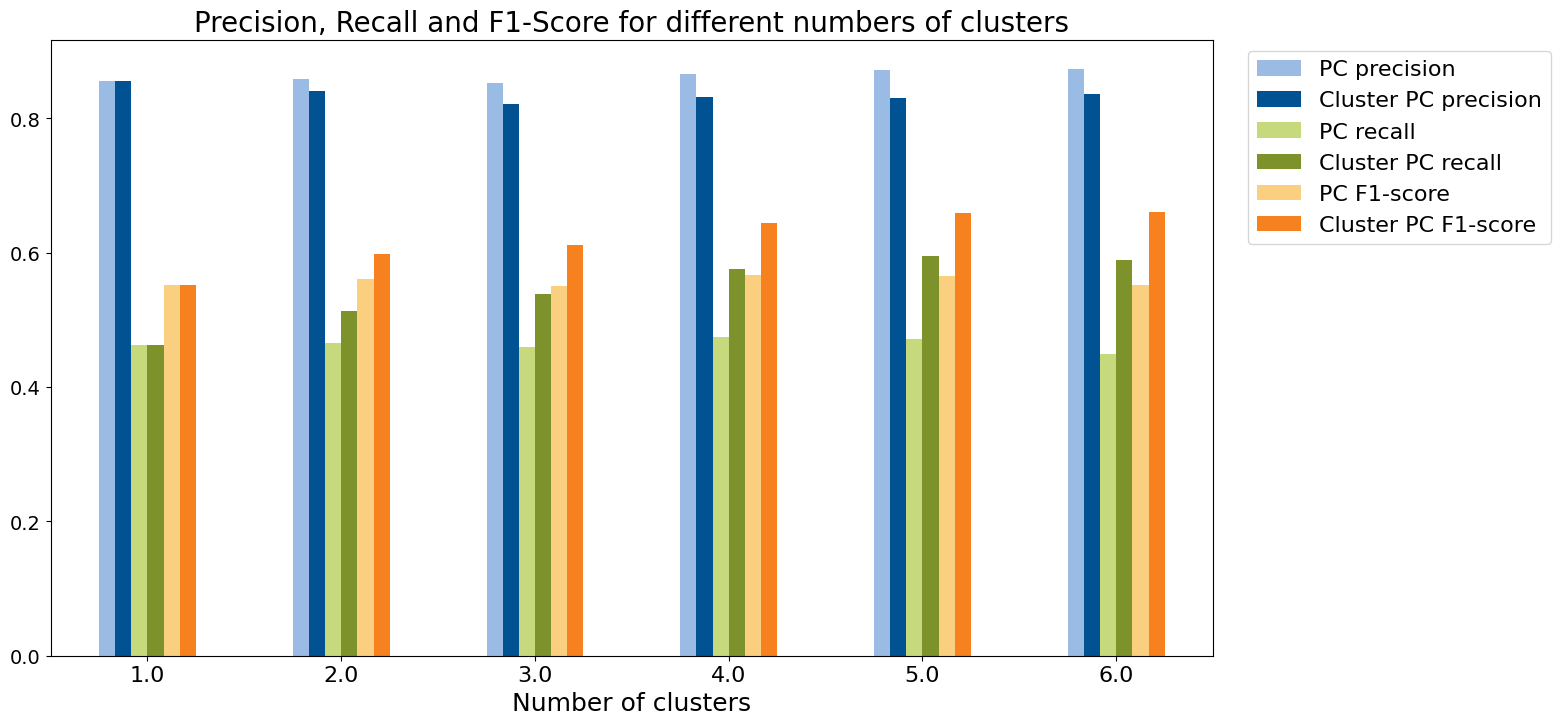

In [27]:
# colors = ['#A4C2F4', '#3333FF', '#64d2a6', '#065535', '#e49645', '#b45f06']
# colors = ['#A4C2F4', '#3333FF', '#64d2a6', '#065535', '#e49645', '#b45f06']
colors = ['#9ABCE4', '#005293', '#C7D97D', '#7D922A', '#FAD080', '#F7811E'] #TUM COLORS
# colors = ['#64a0c8', '#005293', '#8F81EA', '#6955E2', '#FAD080', '#F7811E']
data_all.groupby('n_clusters')[prec_recall_metrics].mean().plot(kind='bar', figsize=(15, 8), color = colors)
plt.title('Precision, Recall and F1-Score for different numbers of clusters', fontsize = 20)
plt.xlabel('Number of clusters', fontsize=18)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.tick_params(axis = 'x', which = 'major', labelsize = 16, rotation = 0)
label_names = ['PC precision', 'Cluster PC precision', 'PC recall', 'Cluster PC recall', 'PC F1-score', 'Cluster PC F1-score']
plt.legend(label_names,  bbox_to_anchor = (1.3, 1),  fontsize=16, loc='upper right')

In [28]:
# # colors = ['#A4C2F4', '#3333FF', '#64d2a6', '#065535', '#e49645', '#b45f06']
# colors = ['#9ABCE4', '#005293', '#C7D97D', '#7D922A', '#FAD080', '#F7811E'] #TUM COLORS
# data_nonadj_clusters.groupby('n_clusters').mean()[prec_recall_metrics].plot(kind='bar', figsize=(15, 8), color = colors)
# plt.title('Precision, Recall and F1-Score for different numbers of clusters for not fully connected C-DAGs', fontsize = 20)
# plt.xlabel('Number of clusters', fontsize=18)
# plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
# plt.tick_params(axis = 'x', which = 'major', labelsize = 16, rotation = 0)
# label_names = ['PC precision', 'Cluster PC precision', 'PC recall', 'Cluster PC recall', 'PC F1-score', 'Cluster PC F1-score']
# plt.legend(label_names,  bbox_to_anchor = (1.3, 1),  fontsize=16, loc='upper right')

In [29]:
data_all.groupby('n_clusters')[dist_metrics].mean()

,base_base_shd,cluster_cluster_shd,empty_graph_shd
n_clusters,,,
1.0,40.866667,40.866667,50.650000
2.0,39.805556,37.205556,50.333333
3.0,40.750000,35.877778,50.433333
4.0,39.300000,33.405556,49.894444
5.0,40.105556,32.383333,50.461111
6.0,41.400000,32.594444,51.805556


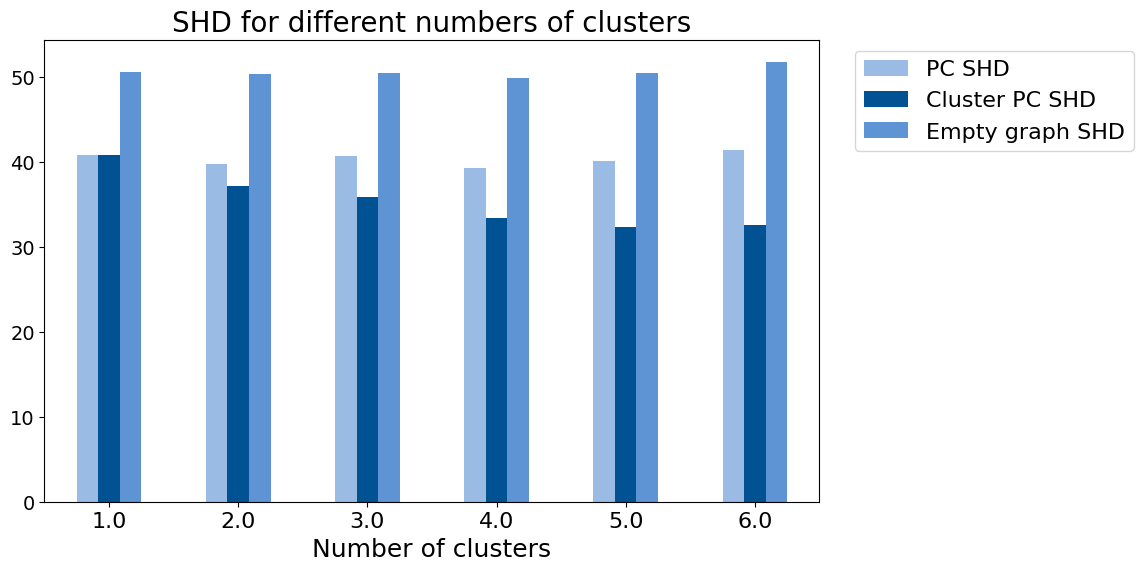

In [30]:
# colors = ['#A4C2F4', '#3333FF', '#4D68D5']
colors = ['#9ABCE4', '#005293', '#5E94D4']
data_all.groupby('n_clusters')[dist_metrics].mean().plot(kind='bar', figsize=(10, 6), color = colors)
plt.title('SHD for different numbers of clusters', fontsize = 20)
plt.xlabel('Number of clusters', fontsize=18)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.tick_params(axis = 'x', which = 'major', labelsize = 16, rotation = 0)
label_names = ['PC SHD', 'Cluster PC SHD', 'Empty graph SHD']
plt.legend(label_names, bbox_to_anchor = (1.42, 1),  fontsize=16, loc='upper right')

In [31]:
data_nonadj_clusters.groupby('n_clusters')[dist_metrics].mean()

,base_base_shd,cluster_cluster_shd,empty_graph_shd
n_clusters,,,
3.0,19.093750,19.062500,25.406250
4.0,28.954545,25.284091,39.465909
5.0,33.343284,27.134328,43.529851
6.0,39.288344,31.012270,49.711656


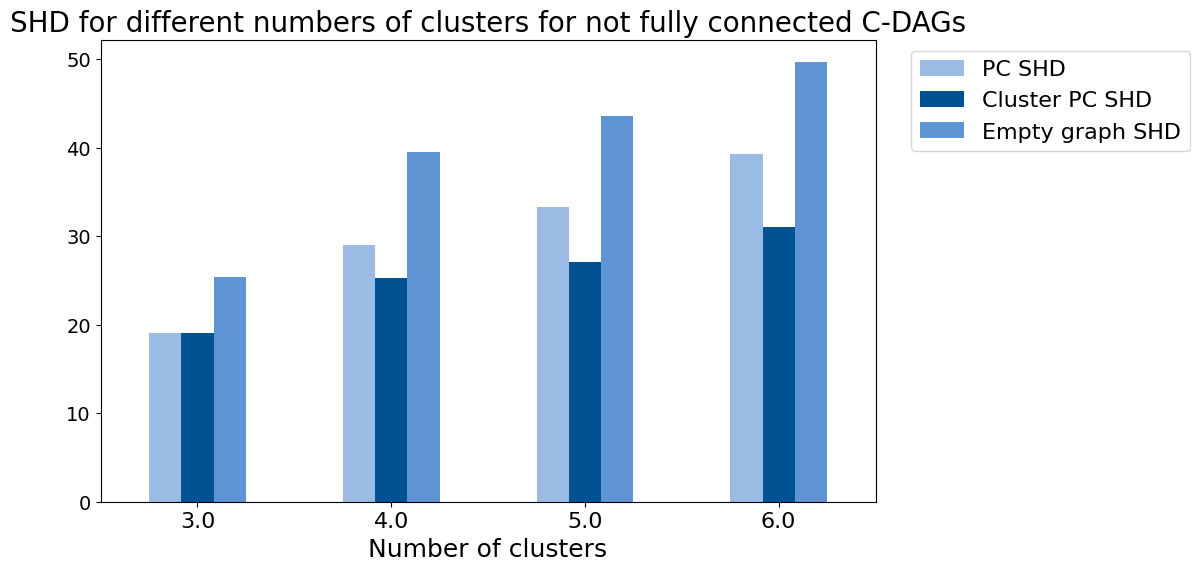

In [32]:
# colors = ['#A4C2F4', '#3333FF', '#4D68D5']
colors = ['#9ABCE4', '#005293', '#5E94D4']
data_nonadj_clusters.groupby('n_clusters')[dist_metrics].mean().plot(kind='bar', figsize=(10, 6), color = colors)
plt.title('SHD for different numbers of clusters for not fully connected C-DAGs', fontsize = 20)
plt.xlabel('Number of clusters', fontsize=18)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.tick_params(axis = 'x', which = 'major', labelsize = 16, rotation = 0)
label_names = ['PC SHD', 'Cluster PC SHD', 'Empty graph SHD']
plt.legend(label_names, bbox_to_anchor = (1.42, 1),  fontsize=16, loc='upper right')

Goes up as less C-DAGs are fully connected at 5,6 or 7 clusters

In [33]:
indep_test_metrics = ['Base indep tests', 'C-PC indep tests']
data_all.groupby('n_clusters')[indep_test_metrics].mean()

,Base indep tests,C-PC indep tests
n_clusters,,
1.0,4619.927778,4619.927778
2.0,4548.122222,3481.400000
3.0,4630.138889,2949.438889
4.0,4431.344444,2511.738889
5.0,4598.761111,2315.611111
6.0,4654.472222,2089.266667


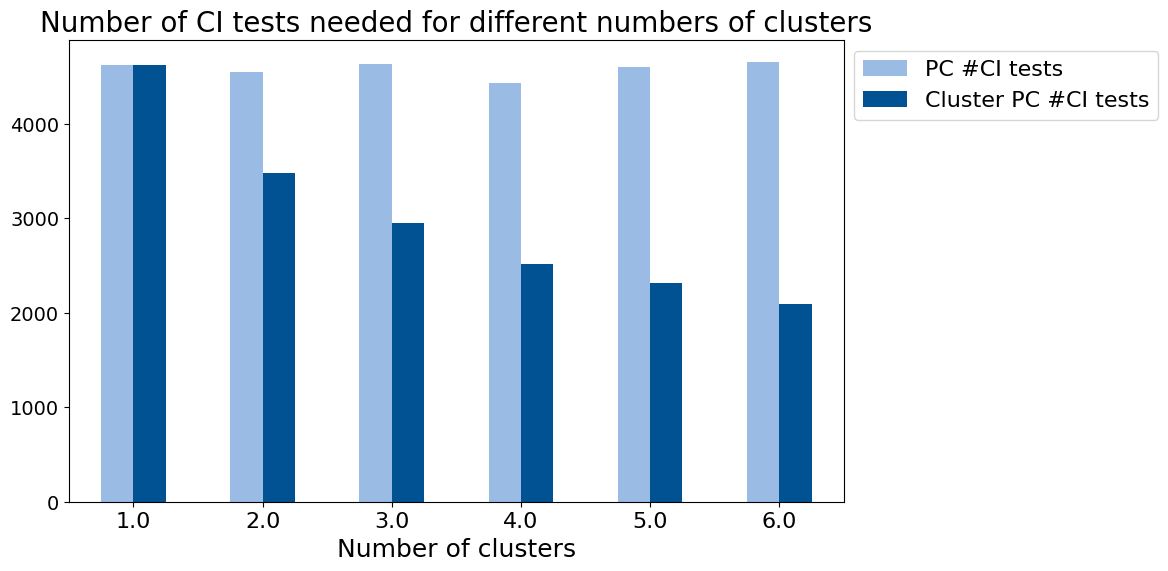

In [34]:
# colors = ['#A4C2F4', '#3333FF', '#4D68D5']
colors = ['#9ABCE4', '#005293', '#5E94D4']
data_all.groupby('n_clusters')[indep_test_metrics].mean().plot(kind='bar', figsize=(10, 6), color = colors)
plt.title('Number of CI tests needed for different numbers of clusters', fontsize = 20)
plt.xlabel('Number of clusters', fontsize=18)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.tick_params(axis = 'x', which = 'major', labelsize = 16, rotation = 0)
label_names = ['PC #CI tests', 'Cluster PC #CI tests']
plt.legend(label_names, bbox_to_anchor = (1.42, 1),  fontsize=16, loc='upper right')

### Grouping by alpha

In [35]:
data.groupby('alpha')[prec_recall_metrics].mean()

,base_adj_precision,cluster_adj_precision,base_adj_recall,cluster_adj_recall,base_adj_f1_score,cluster_adj_f1_score
alpha,,,,,,
0.01,0.916112,0.902991,0.429894,0.524422,0.551538,0.640852
0.05,0.904338,0.885166,0.445340,0.537709,0.559914,0.642846
0.10,0.894794,0.866311,0.455244,0.556900,0.565258,0.650317
0.25,0.834739,0.792300,0.480221,0.586292,0.563331,0.636353
0.50,0.772943,0.714490,0.509988,0.604982,0.555869,0.603745


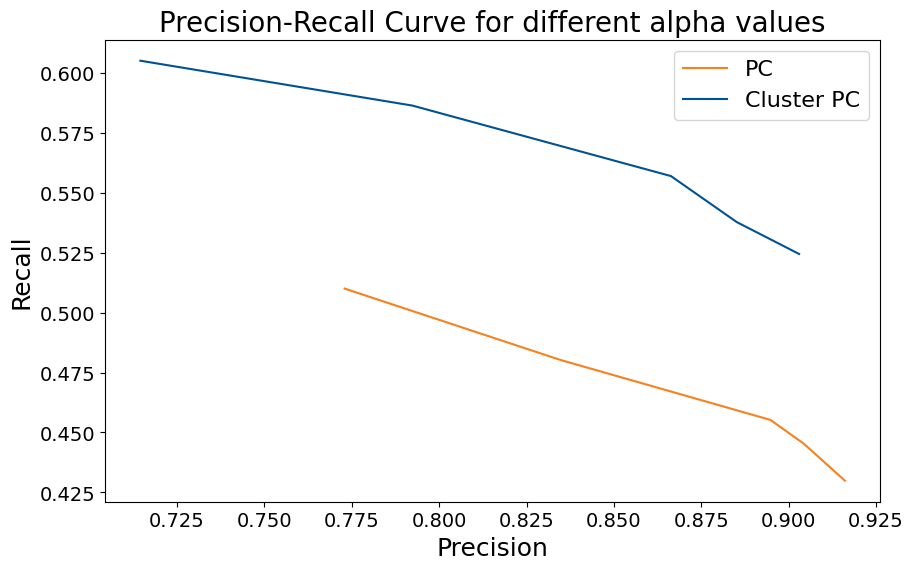

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
# colors = ['#9ABCE4', '#005293', '#C7D97D', '#7D922A', '#FAD080', '#F7811E'] #TUM COLORS
ax.plot(data.groupby('alpha')['base_adj_precision'].mean(), data.groupby('alpha')['base_adj_recall'].mean(), color = '#F7811E')
ax.plot(data.groupby('alpha')['cluster_adj_precision'].mean(), data.groupby('alpha')['cluster_adj_recall'].mean(), color = '#005293')
ax.set_title('Precision-Recall Curve for different alpha values', fontsize = 20)
ax.set_xlabel('Precision', fontsize=18)
ax.set_ylabel('Recall', fontsize=18)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax.legend(['PC', 'Cluster PC'], fontsize=16)

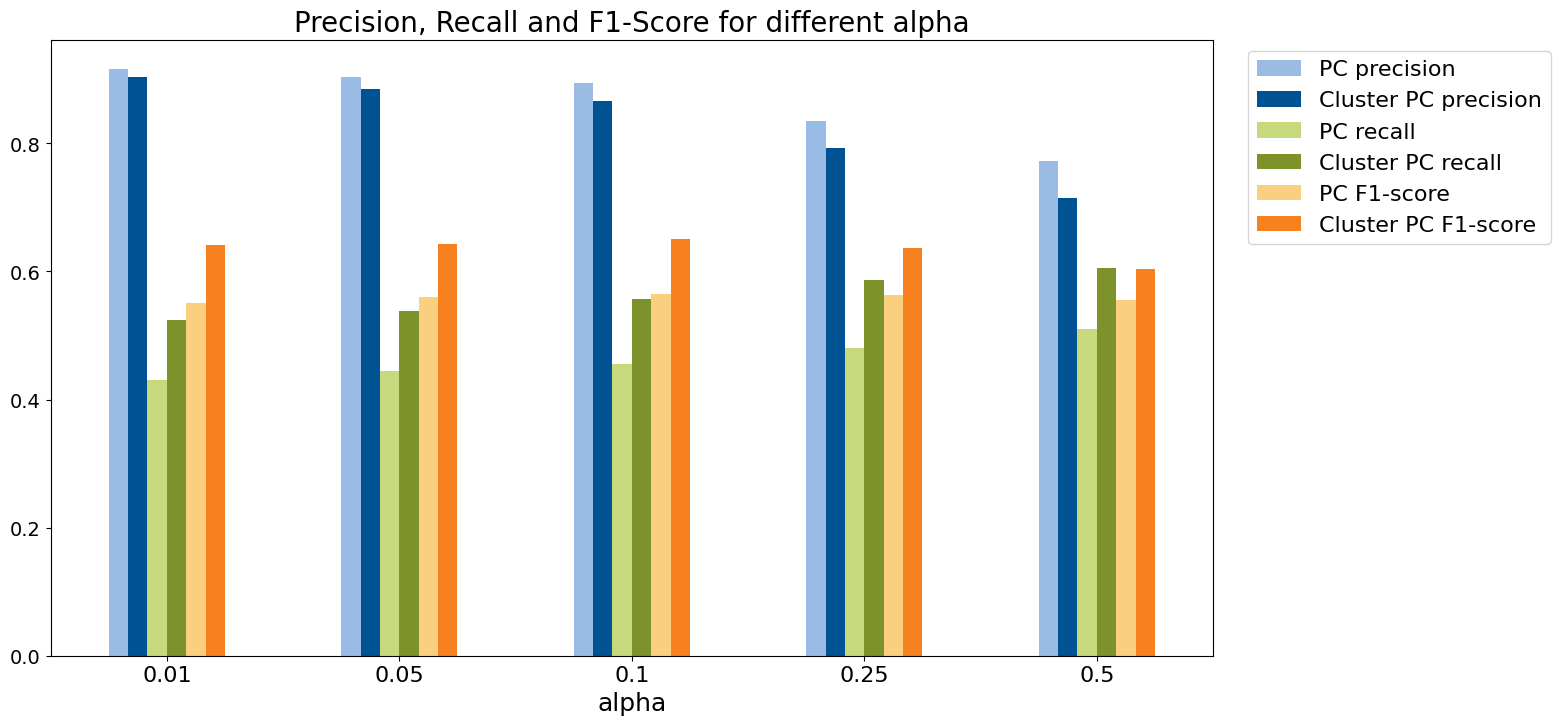

In [37]:
# colors = ['#A4C2F4', '#3333FF', '#64d2a6', '#065535', '#e49645', '#b45f06']
colors = ['#9ABCE4', '#005293', '#C7D97D', '#7D922A', '#FAD080', '#F7811E'] #TUM COLORS
data.groupby('alpha')[prec_recall_metrics].mean().plot(kind='bar', figsize=(15, 8), color = colors)
plt.title('Precision, Recall and F1-Score for different alpha', fontsize = 20)
plt.xlabel('alpha', fontsize=18)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.tick_params(axis = 'x', which = 'major', labelsize = 16, rotation = 0)
label_names = ['PC precision', 'Cluster PC precision', 'PC recall', 'Cluster PC recall', 'PC F1-score', 'Cluster PC F1-score']
plt.legend(label_names, bbox_to_anchor = (1.3, 1),  fontsize=16, loc='upper right')

In [38]:
data.groupby('alpha')[dist_metrics].mean()

,base_base_shd,cluster_cluster_shd,empty_graph_shd
alpha,,,
0.01,40.061111,33.483333,50.472222
0.05,39.561111,33.772222,50.855556
0.10,39.772222,33.088889,50.838889
0.25,40.022222,33.855556,50.072222
0.50,41.944444,37.266667,50.688889


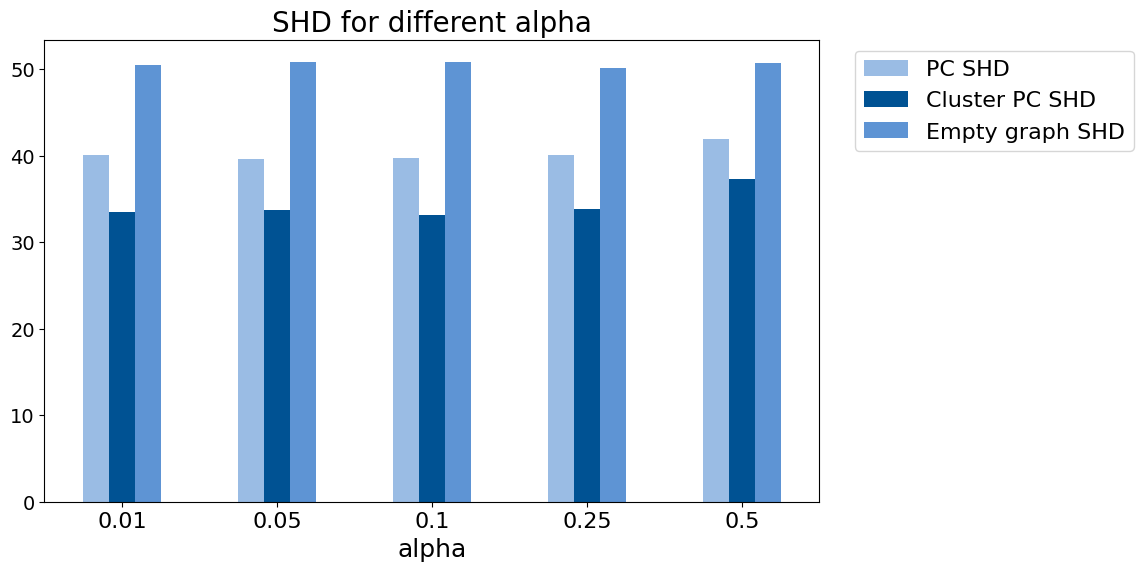

In [39]:
# colors = ['#A4C2F4', '#3333FF', '#4D68D5']
colors = ['#9ABCE4', '#005293', '#5E94D4']
data.groupby('alpha')[dist_metrics].mean().plot(kind='bar', figsize=(10, 6), color = colors)
plt.title('SHD for different alpha', fontsize = 20)
plt.xlabel('alpha', fontsize=18)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.tick_params(axis = 'x', which = 'major', labelsize = 16, rotation = 0)
label_names = ['PC SHD', 'Cluster PC SHD', 'Empty graph SHD']
plt.legend(label_names, bbox_to_anchor = (1.42, 1),  fontsize=16, loc='upper right')

### Grouping by distribution type


In [40]:
data.groupby('distribution_type')[prec_recall_metrics].mean()

,base_adj_precision,cluster_adj_precision,base_adj_recall,cluster_adj_recall,base_adj_f1_score,cluster_adj_f1_score
distribution_type,,,,,,
exp,0.857808,0.828024,0.464721,0.564380,0.557131,0.635359
gauss,0.869965,0.837394,0.465413,0.564434,0.562328,0.638352
gumbel,0.865983,0.831336,0.462278,0.557369,0.558088,0.630756


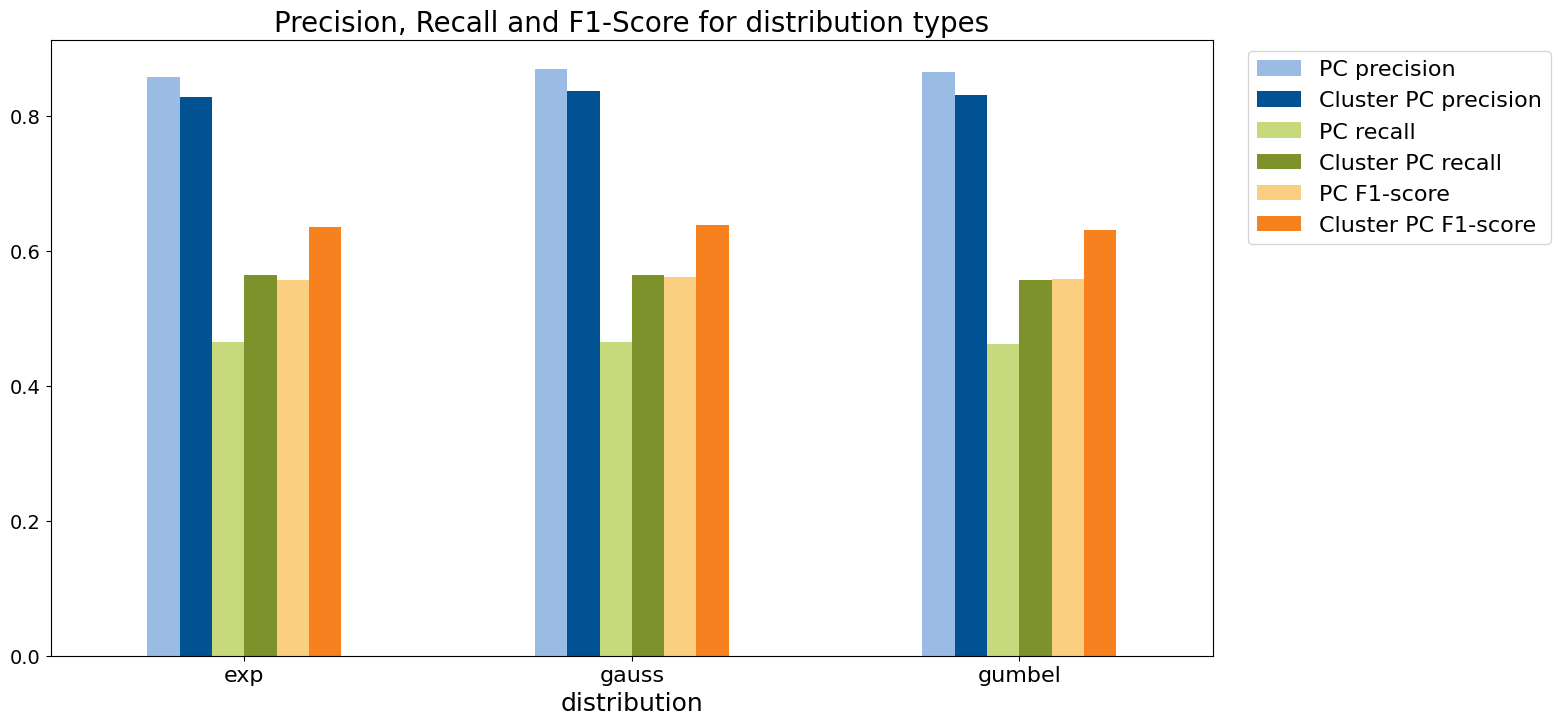

In [41]:
# colors = ['#A4C2F4', '#3333FF', '#64d2a6', '#065535', '#e49645', '#b45f06']
colors = ['#9ABCE4', '#005293', '#C7D97D', '#7D922A', '#FAD080', '#F7811E'] #TUM COLORS
data.groupby('distribution_type')[prec_recall_metrics].mean().plot(kind='bar', figsize=(15, 8), color = colors)
plt.title('Precision, Recall and F1-Score for distribution types', fontsize = 20)
plt.xlabel('distribution', fontsize=18)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.tick_params(axis = 'x', which = 'major', labelsize = 16, rotation = 0)
label_names = ['PC precision', 'Cluster PC precision', 'PC recall', 'Cluster PC recall', 'PC F1-score', 'Cluster PC F1-score']
plt.legend(label_names, bbox_to_anchor = (1.3, 1),  fontsize=16, loc='upper right')

In [42]:
data.groupby('distribution_type')[dist_metrics].mean()

,base_base_shd,cluster_cluster_shd,empty_graph_shd
distribution_type,,,
exp,40.310000,34.326667,50.520000
gauss,40.123333,33.933333,50.453333
gumbel,40.383333,34.620000,50.783333


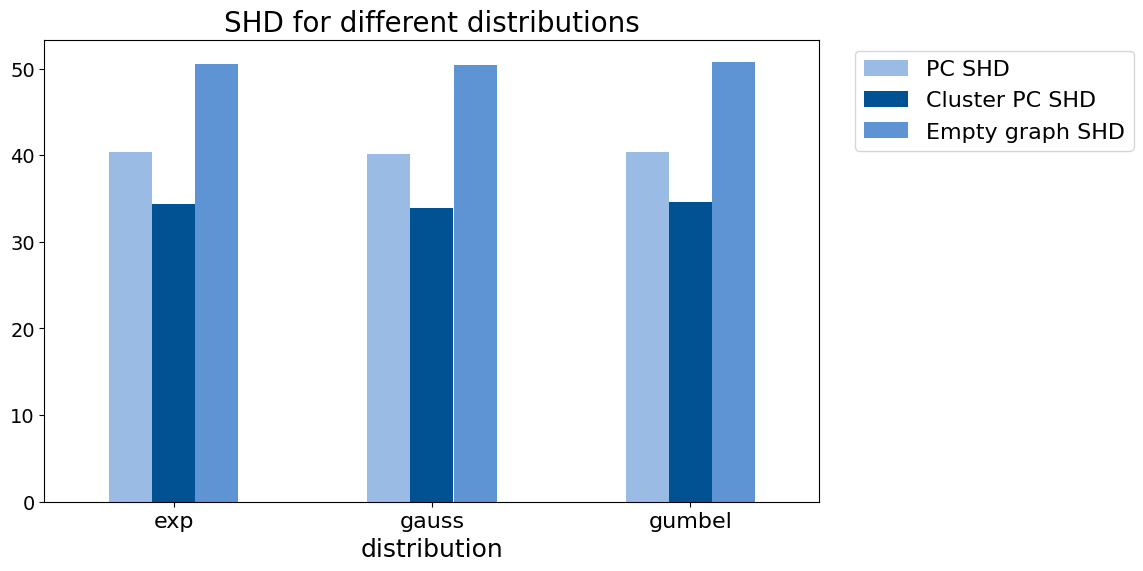

In [43]:
# colors = ['#A4C2F4', '#3333FF', '#4D68D5']
colors = ['#9ABCE4', '#005293', '#5E94D4']
data.groupby('distribution_type')[dist_metrics].mean().plot(kind='bar', figsize=(10, 6), color = colors)
plt.title('SHD for different distributions', fontsize = 20)
plt.xlabel('distribution', fontsize=18)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.tick_params(axis = 'x', which = 'major', labelsize = 16, rotation = 0)
label_names = ['PC SHD', 'Cluster PC SHD', 'Empty graph SHD']
plt.legend(label_names, bbox_to_anchor = (1.42, 1),  fontsize=16, loc='upper right')

### Grouping by DAG method

In [44]:
data.groupby('dag_method')[prec_recall_metrics].mean()

,base_adj_precision,cluster_adj_precision,base_adj_recall,cluster_adj_recall,base_adj_f1_score,cluster_adj_f1_score
dag_method,,,,,,
erdos_renyi,0.848732,0.808552,0.544638,0.635218,0.618296,0.675626
hierarchical,0.903317,0.891991,0.248063,0.367453,0.386609,0.515766
scale_free,0.841707,0.796212,0.599711,0.683512,0.672641,0.713075


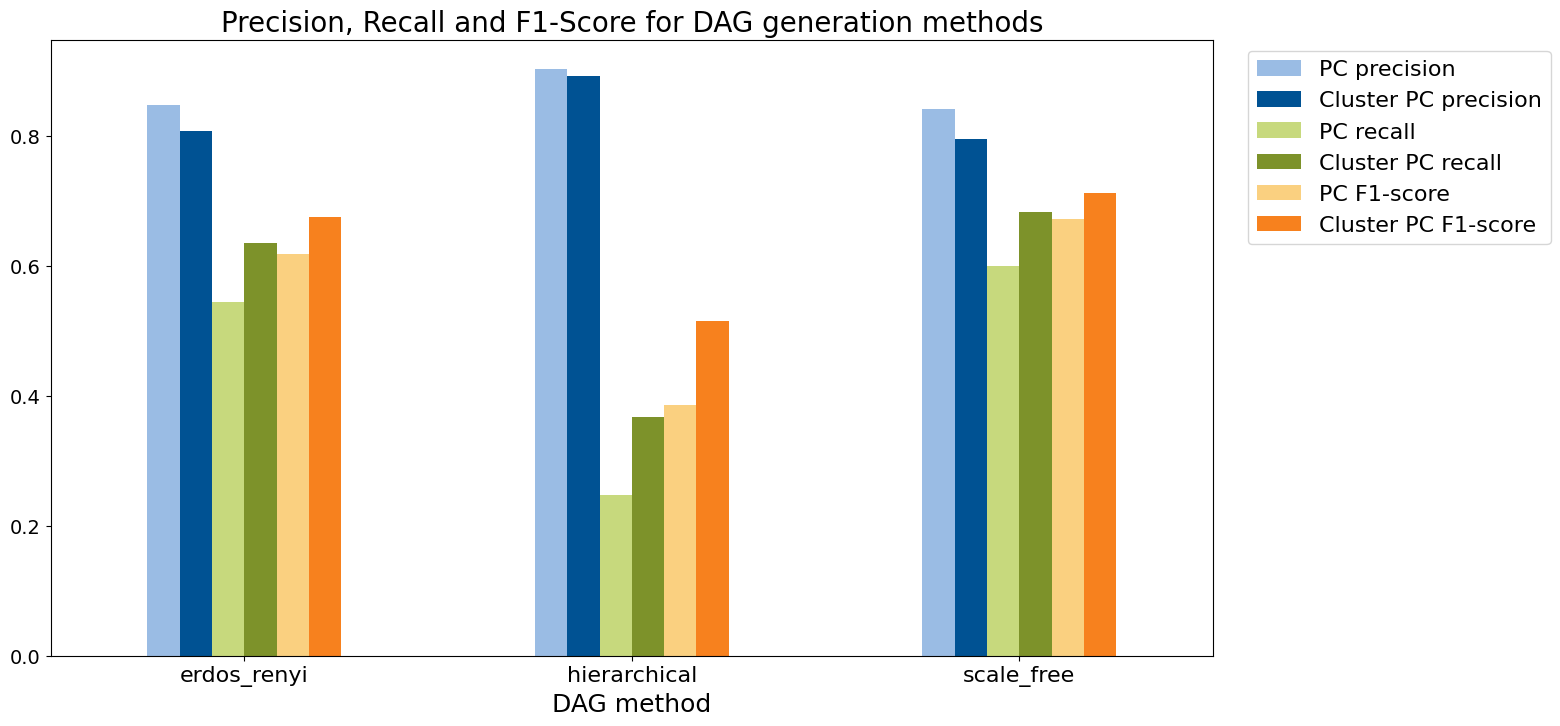

In [45]:
# colors = ['#A4C2F4', '#3333FF', '#64d2a6', '#065535', '#e49645', '#b45f06']
colors = ['#9ABCE4', '#005293', '#C7D97D', '#7D922A', '#FAD080', '#F7811E'] #TUM COLORS
data.groupby('dag_method')[prec_recall_metrics].mean().plot(kind='bar', figsize=(15, 8), color = colors)
plt.title('Precision, Recall and F1-Score for DAG generation methods', fontsize = 20)
plt.xlabel('DAG method', fontsize=18)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.tick_params(axis = 'x', which = 'major', labelsize = 16, rotation = 0)
label_names = ['PC precision', 'Cluster PC precision', 'PC recall', 'Cluster PC recall', 'PC F1-score', 'Cluster PC F1-score']
plt.legend(label_names, bbox_to_anchor = (1.3, 1),  fontsize=16, loc='upper right')

In [46]:
data.groupby('dag_method')[dist_metrics].mean()

,base_base_shd,cluster_cluster_shd,empty_graph_shd
dag_method,,,
erdos_renyi,32.130000,27.410000,40.443333
hierarchical,65.573333,56.003333,79.813333
scale_free,23.113333,19.466667,31.500000


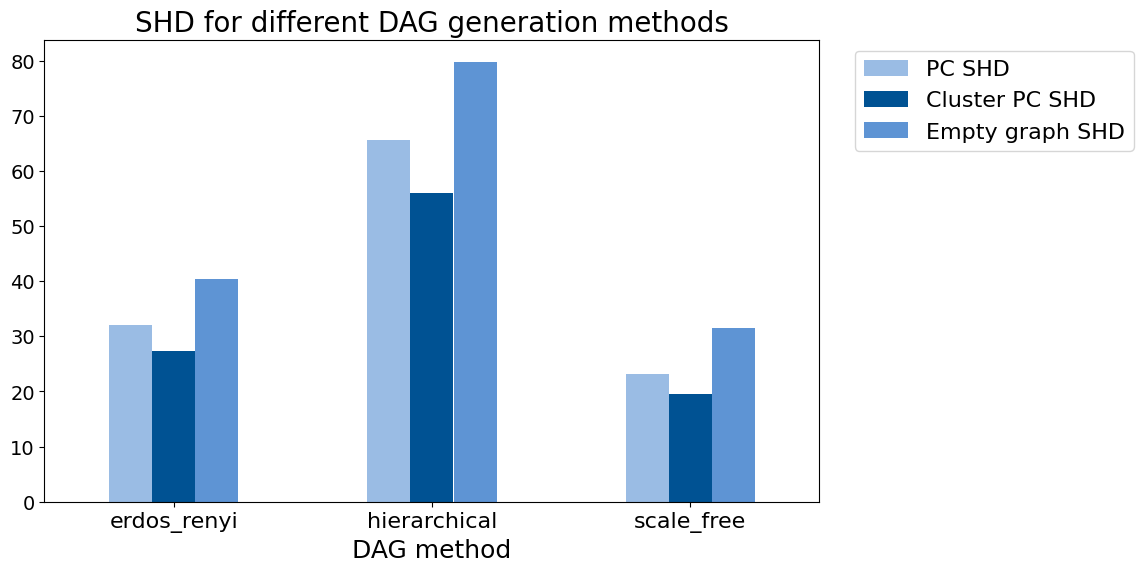

In [47]:
# colors = ['#A4C2F4', '#3333FF', '#4D68D5']
colors = ['#9ABCE4', '#005293', '#5E94D4']
data.groupby('dag_method')[dist_metrics].mean().plot(kind='bar', figsize=(10, 6), color = colors)
plt.title('SHD for different DAG generation methods', fontsize = 20)
plt.xlabel('DAG method', fontsize=18)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.tick_params(axis = 'x', which = 'major', labelsize = 16, rotation = 0)
label_names = ['PC SHD', 'Cluster PC SHD', 'Empty graph SHD']
plt.legend(label_names, bbox_to_anchor = (1.42, 1),  fontsize=16, loc='upper right')

### Grouping by #edges

In [48]:
data.groupby('n_edges')[prec_recall_metrics].mean()

,base_adj_precision,cluster_adj_precision,base_adj_recall,cluster_adj_recall,base_adj_f1_score,cluster_adj_f1_score
n_edges,,,,,,
15.0,0.843480,0.801699,0.679761,0.736713,0.684001,0.710425
30.0,0.885125,0.845446,0.521864,0.615081,0.627920,0.685672
50.0,0.872614,0.837464,0.384349,0.499568,0.518946,0.610957
80.0,0.857122,0.844398,0.270576,0.396882,0.405862,0.532237


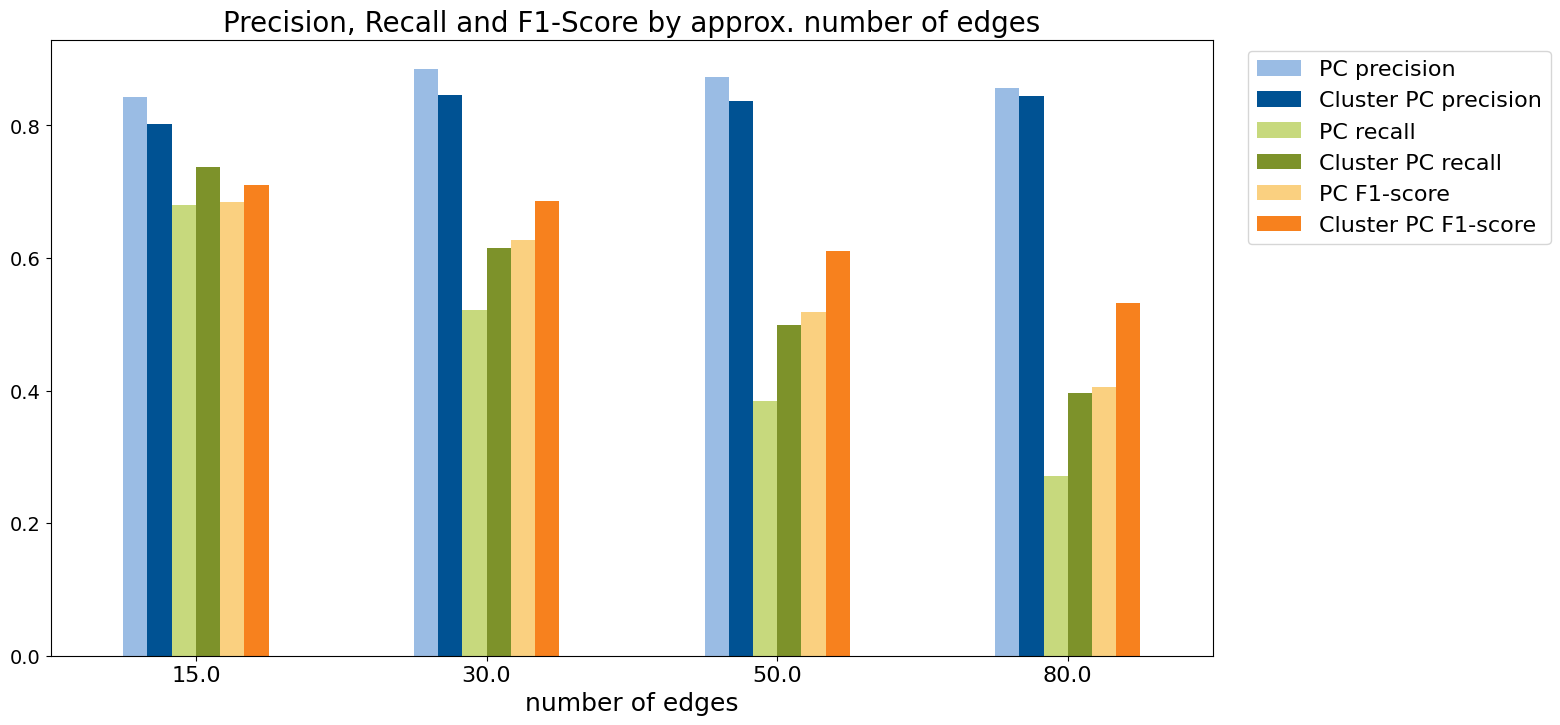

In [49]:
# colors = ['#A4C2F4', '#3333FF', '#64d2a6', '#065535', '#e49645', '#b45f06']
colors = ['#9ABCE4', '#005293', '#C7D97D', '#7D922A', '#FAD080', '#F7811E'] #TUM COLORS
data.groupby('n_edges')[prec_recall_metrics].mean().plot(kind='bar', figsize=(15, 8), color = colors)
plt.title('Precision, Recall and F1-Score by approx. number of edges', fontsize = 20)
plt.xlabel('number of edges', fontsize=18)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.tick_params(axis = 'x', which = 'major', labelsize = 16, rotation = 0)
label_names = ['PC precision', 'Cluster PC precision', 'PC recall', 'Cluster PC recall', 'PC F1-score', 'Cluster PC F1-score']
plt.legend(label_names, bbox_to_anchor = (1.3, 1),  fontsize=16, loc='upper right')

In [50]:
data.groupby('n_edges')[dist_metrics].mean()

,base_base_shd,cluster_cluster_shd,empty_graph_shd
n_edges,,,
15.0,26.782222,23.475556,35.751111
30.0,32.364444,27.582222,44.253333
50.0,43.017778,36.262222,53.933333
80.0,58.924444,49.853333,68.404444


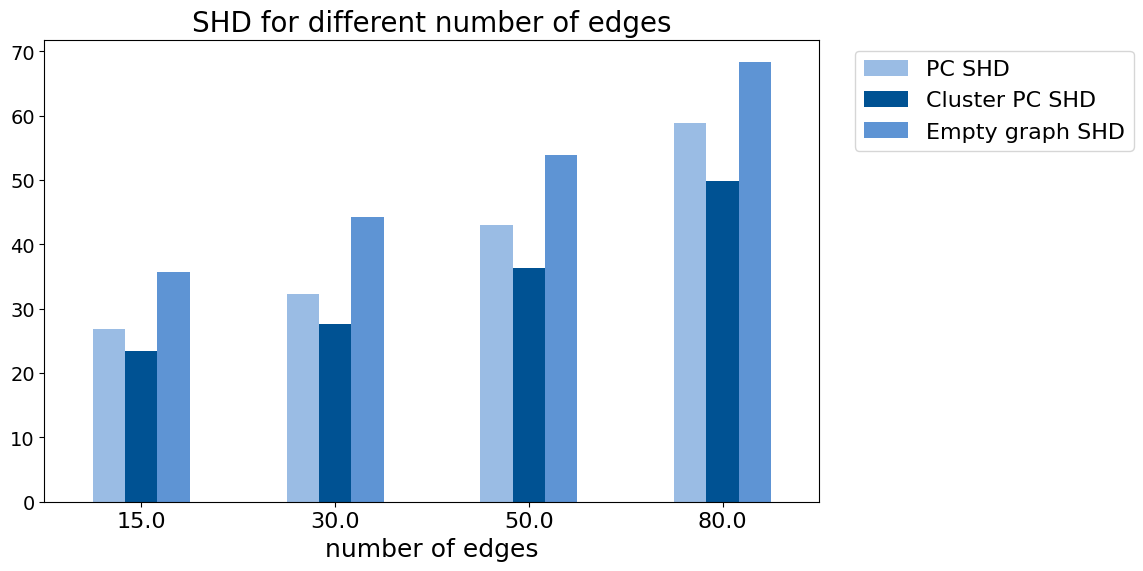

In [51]:
# colors = ['#A4C2F4', '#3333FF', '#4D68D5']
colors = ['#9ABCE4', '#005293', '#5E94D4']
data.groupby('n_edges')[dist_metrics].mean().plot(kind='bar', figsize=(10, 6), color = colors)
plt.title('SHD for different number of edges', fontsize = 20)
plt.xlabel('number of edges', fontsize=18)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.tick_params(axis = 'x', which = 'major', labelsize = 16, rotation = 0)
label_names = ['PC SHD', 'Cluster PC SHD', 'Empty graph SHD']
plt.legend(label_names, bbox_to_anchor = (1.42, 1),  fontsize=16, loc='upper right')